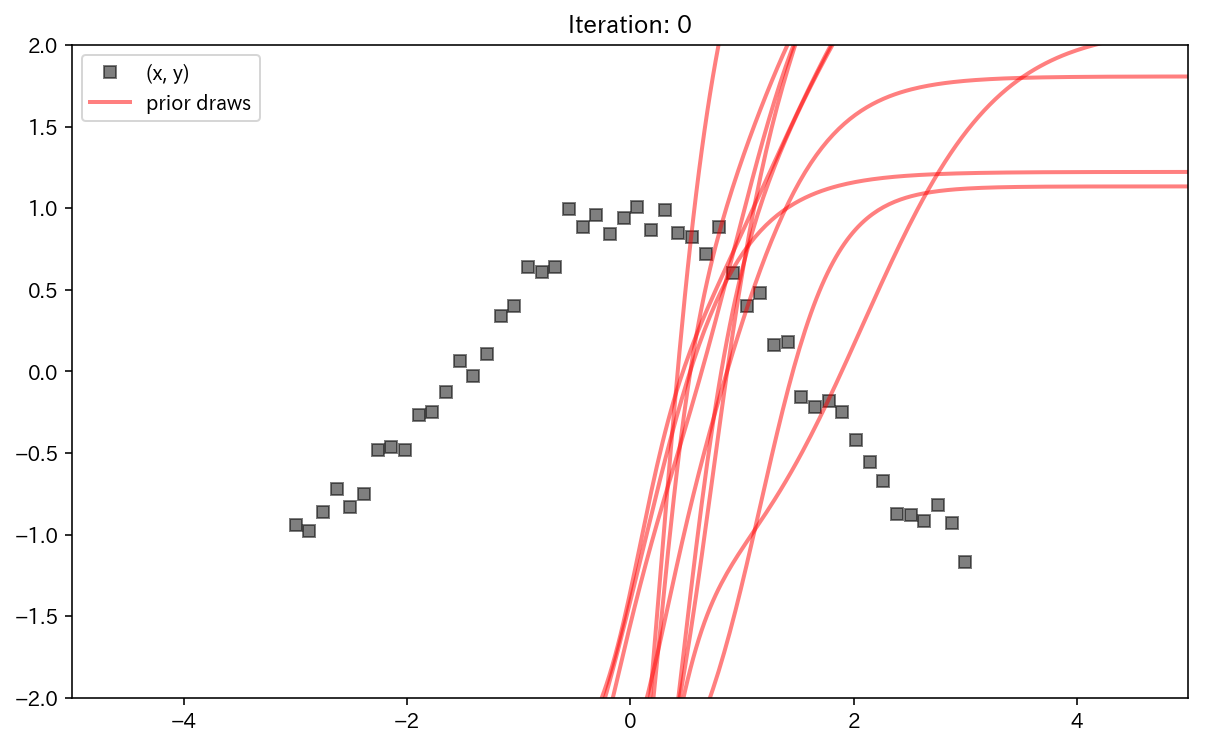

In [1]:
import numpy as np 
import pandas as pd
import scipy as sp 
import tensorflow as tf 
import edward as ed
from tensorflow.python import debug as tf_debug
import matplotlib.pyplot as plt 
import seaborn as sns
from edward.models import Normal, Empirical, PointMass, Exponential, Poisson
%matplotlib inline

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

ed.set_seed(42)
N = 50
D = 1 

def build_toy_dataset(N=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y

def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

# data
x_train, y_train = build_toy_dataset(N)

# model
x = x_train 
with tf.name_scope("model"):
    W_0 = Normal(loc=tf.zeros([D, 2], name="weights0/loc"),
             scale=tf.ones([D, 2], name="weights0/scale"),
            name="weight0")
    W_1 = Normal(loc=tf.zeros([2, 1], name="weights0/loc"),
                 scale=tf.ones([2, 1], name="weights0/scale"),
                name="weight1")
    b_0 = Normal(loc=tf.zeros(2, name="bias0/loc"),
                 scale=tf.ones(2, name="bias0/scale"),
                name="bias0")
    b_1 = Normal(loc=tf.zeros(1, name="bias1/loc"),
                 scale=tf.ones(1, name="bias1/scale"),
                name="bias1")
    y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
                scale=tf.ones(1, name="y/scale")*0.5,
              name="y")

# inference
with tf.name_scope("posterior"):
    qW0 = Normal(loc=tf.Variable(tf.random_normal([D, 2]), name="qw0/loc"),
                 scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, 2]), name="qw0/unconstrained_scale")),
                name="qw0")
    qW1 = Normal(loc=tf.Variable(tf.random_normal([2, 1]), name="qw1/loc"),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([2, 1]), name="qw1/unconstrained_scale")),
                name="qw1")
    qb0 = Normal(loc=tf.Variable(tf.random_normal([2]), name="qb0/loc"),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([2]), name="qb0/unconstrained_scale")),
                name="qb0")
    qb1 = Normal(loc=tf.Variable(tf.random_normal([1]), name="qb0/loc"),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]), name="qb0/unconstrained_scale")),
                name="qb1")

rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, 400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack([
    neural_network(x, qW0.sample(), qW1.sample(), qb0.sample(), qb1.sample())
     for _ in range(10)
])

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [2]:
inference = ed.KLqp({W_0:qW0, W_1:qW1, b_0:qb0, b_1:qb1}, data={y:y_train})
inference.run(n_samples=5, logdir='log/n_samples_5')

1000/1000 [100%] ██████████████████████████████ Elapsed: 19s | Loss: 35.968


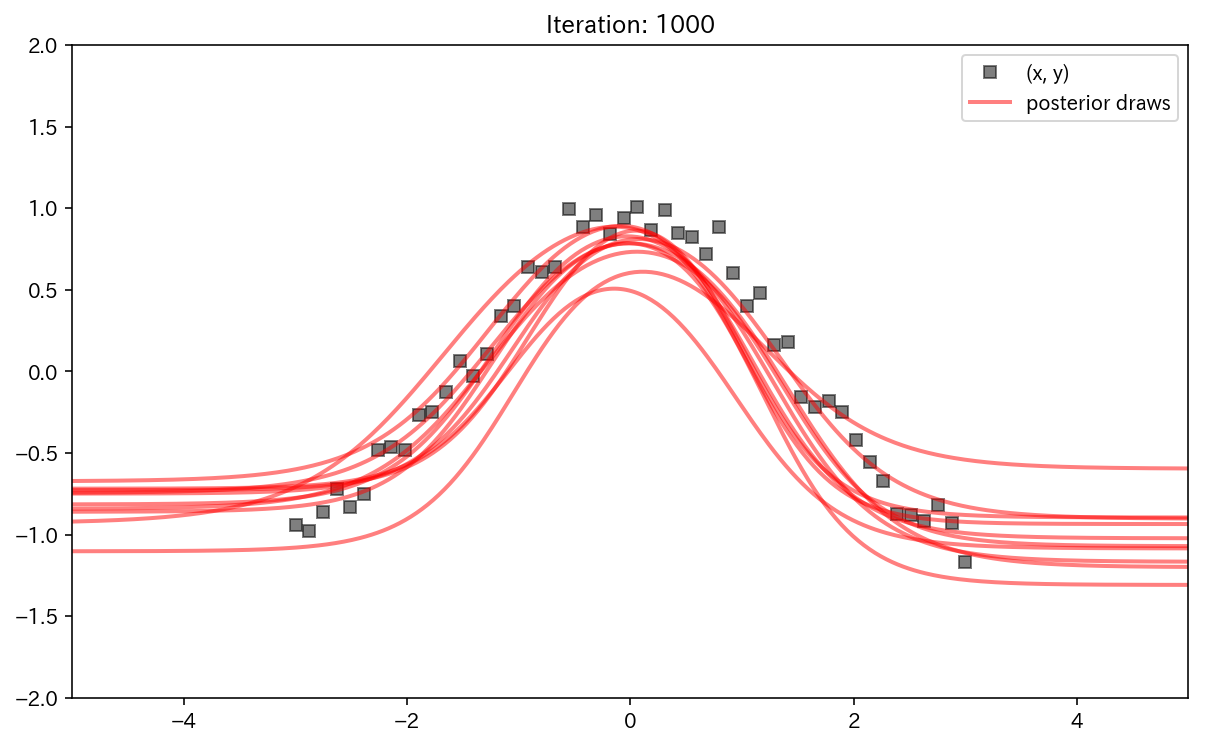

In [3]:
mus = tf.stack([
    neural_network(x, qW0.sample(), qW1.sample(), qb0.sample(), qb1.sample())
     for _ in range(10)
])

outputs = mus.eval()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()